### Обучение лучшей модели ResNet на полном датасете

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import transforms
from torchvision import models 
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from torchvision.datasets import ImageFolder

In [9]:
num_classes = 75  # Количество пород собак
batch_size = 32
epochs = 30


class DogDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = []
        self.labels = []  # Добавляем атрибут для хранения меток
        self.transform = transform
        
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append((os.path.join(cls_dir, img_name), self.class_to_idx[cls]))
                    self.labels.append(self.class_to_idx[cls])  # Сохраняем метку
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [10]:
# Аугментации
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

full_dataset = DogDataset(
    root_dir="C:/Users/User/.cache/kagglehub/datasets/darshanthakare/dog-breeds-image-dataset/versions/1/cropped_dogs",
    transform=train_transform  )

train_idx, temp_idx = train_test_split(
    range(len(full_dataset)),
    test_size=0.2,
    stratify=full_dataset.labels,  # Важно для баланса классов
    random_state=42)


val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=[full_dataset.labels[i] for i in temp_idx],
    random_state=42)

train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
val_dataset = torch.utils.data.Subset(full_dataset, val_idx)
test_dataset = torch.utils.data.Subset(full_dataset, test_idx)

val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [20]:
# Проверка устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_3 = models.resnet18(weights=None)  # Не загружаем ImageNet веса

# Загрузка сохранённых весов с обработкой несоответствия
checkpoint = torch.load('best_model_resnet18_pred.pth')

del checkpoint['fc.weight']
del checkpoint['fc.bias']

# Создаём новый последний слой для 75 классов
num_classes = 75
model_3.fc = nn.Linear(model_3.fc.in_features, num_classes)

# Загружаем веса (strict=False пропускает несовпадающие ключи)
model_3.load_state_dict(checkpoint, strict=False)
model_3 = model_3.to(device)

criterion_3 = nn.CrossEntropyLoss()
optimizer_3 = optim.Adam(model_3.parameters(), lr=0.001)

In [21]:
def calculate_metrics(outputs, labels):
    """Корректное вычисление метрик"""
    # Получаем предсказанные классы
    _, preds = torch.max(outputs, 1)
    
    # Преобразуем в numpy arrays
    preds = preds.detach().cpu().numpy().flatten()  # Используем flatten вместо ravel
    labels = labels.detach().cpu().numpy().flatten()
    
    # Вычисляем метрики
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)
    f1 = f1_score(labels, preds, average='weighted', zero_division=0)
    
    return accuracy, precision, recall, f1, preds, labels

def evaluate_model(model, criterion, dataloader):
    """Оценка модели"""
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0
    running_precision = 0.0
    running_recall = 0.0
    running_f1 = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            acc, prec, rec, f1, preds, true_labels = calculate_metrics(outputs, labels)
            
            running_accuracy += acc * inputs.size(0)
            running_precision += prec * inputs.size(0)
            running_recall += rec * inputs.size(0)
            running_f1 += f1 * inputs.size(0)
            all_preds.extend(preds)
            all_labels.extend(true_labels)
    
    total = len(dataloader.dataset)
    avg_loss = running_loss / total
    avg_acc = running_accuracy / total
    avg_prec = running_precision / total
    avg_rec = running_recall / total
    avg_f1 = running_f1 / total
    
    return avg_loss, avg_acc, avg_prec, avg_rec, avg_f1, all_preds, all_labels

In [23]:
def train_model(model, criterion, optimizer, epochs):
    best_f1 = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1': []}
    
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        print('-' * 10)
        
        # Фаза обучения
        model.train()
        running_loss = 0.0
        running_accuracy = 0.0
        
        for inputs, labels in tqdm(train_loader, desc='Training'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            acc, _, _, _, _, _ = calculate_metrics(outputs, labels)
            running_accuracy += acc * inputs.size(0)
        
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_accuracy / len(train_dataset)
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        
        # Фаза валидации
        val_loss, val_acc, val_prec, val_rec, val_f1, _, _ = evaluate_model(model, criterion, val_loader)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f}')
        
        # Сохраняем лучшую модель
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), 'best_model_resnet18_pred.pth')
    
    return history, model

history, trained_model = train_model(model_3, criterion_3, optimizer_3, epochs)

Epoch 1/30
----------


Evaluating: 100%|██████████| 32/32 [00:24<00:00,  1.31it/s]


Train Loss: 2.5349 Acc: 0.3164
Val Loss: 2.7088 Acc: 0.3162 F1: 0.2906
Epoch 2/30
----------


Evaluating: 100%|██████████| 32/32 [00:18<00:00,  1.69it/s]


Train Loss: 1.5135 Acc: 0.5507
Val Loss: 1.9758 Acc: 0.4615 F1: 0.4446
Epoch 3/30
----------


Evaluating: 100%|██████████| 32/32 [00:19<00:00,  1.66it/s]


Train Loss: 0.9845 Acc: 0.6981
Val Loss: 1.8817 Acc: 0.4951 F1: 0.4860
Epoch 4/30
----------


Evaluating: 100%|██████████| 32/32 [00:19<00:00,  1.68it/s]


Train Loss: 0.6038 Acc: 0.8071
Val Loss: 2.4168 Acc: 0.4417 F1: 0.4367
Epoch 5/30
----------


Evaluating: 100%|██████████| 32/32 [00:18<00:00,  1.75it/s]


Train Loss: 0.3561 Acc: 0.8930
Val Loss: 2.0075 Acc: 0.5109 F1: 0.5054
Epoch 6/30
----------


Evaluating: 100%|██████████| 32/32 [00:18<00:00,  1.75it/s]


Train Loss: 0.2390 Acc: 0.9272
Val Loss: 2.3092 Acc: 0.5010 F1: 0.4923
Epoch 7/30
----------


Evaluating: 100%|██████████| 32/32 [00:18<00:00,  1.76it/s]


Train Loss: 0.2010 Acc: 0.9392
Val Loss: 2.2706 Acc: 0.5188 F1: 0.5146
Epoch 8/30
----------


Evaluating: 100%|██████████| 32/32 [00:18<00:00,  1.76it/s]


Train Loss: 0.1131 Acc: 0.9690
Val Loss: 2.0871 Acc: 0.5445 F1: 0.5344
Epoch 9/30
----------


Evaluating: 100%|██████████| 32/32 [00:18<00:00,  1.77it/s]


Train Loss: 0.1281 Acc: 0.9632
Val Loss: 2.5858 Acc: 0.4842 F1: 0.4732
Epoch 10/30
----------


Evaluating: 100%|██████████| 32/32 [00:18<00:00,  1.75it/s]


Train Loss: 0.2333 Acc: 0.9250
Val Loss: 2.7995 Acc: 0.4239 F1: 0.4080
Epoch 11/30
----------


Evaluating: 100%|██████████| 32/32 [00:18<00:00,  1.75it/s]


Train Loss: 0.2217 Acc: 0.9282
Val Loss: 2.3893 Acc: 0.5069 F1: 0.5012
Epoch 12/30
----------


Evaluating: 100%|██████████| 32/32 [00:18<00:00,  1.76it/s]


Train Loss: 0.1205 Acc: 0.9624
Val Loss: 2.7420 Acc: 0.4743 F1: 0.4610
Epoch 13/30
----------


Evaluating: 100%|██████████| 32/32 [00:18<00:00,  1.72it/s]


Train Loss: 0.1195 Acc: 0.9618
Val Loss: 2.4503 Acc: 0.5257 F1: 0.5157
Epoch 14/30
----------


Evaluating: 100%|██████████| 32/32 [00:25<00:00,  1.24it/s]


Train Loss: 0.0652 Acc: 0.9807
Val Loss: 2.3643 Acc: 0.5405 F1: 0.5280
Epoch 15/30
----------


Evaluating: 100%|██████████| 32/32 [00:24<00:00,  1.30it/s]


Train Loss: 0.0860 Acc: 0.9728
Val Loss: 2.7014 Acc: 0.5208 F1: 0.5166
Epoch 16/30
----------


Evaluating: 100%|██████████| 32/32 [00:24<00:00,  1.30it/s]


Train Loss: 0.0911 Acc: 0.9724
Val Loss: 3.0094 Acc: 0.4545 F1: 0.4476
Epoch 17/30
----------


Evaluating: 100%|██████████| 32/32 [00:24<00:00,  1.28it/s]


Train Loss: 0.1255 Acc: 0.9595
Val Loss: 2.9387 Acc: 0.4872 F1: 0.4760
Epoch 18/30
----------


Evaluating: 100%|██████████| 32/32 [00:25<00:00,  1.27it/s]


Train Loss: 0.1664 Acc: 0.9460
Val Loss: 2.8614 Acc: 0.5138 F1: 0.5053
Epoch 19/30
----------


Evaluating: 100%|██████████| 32/32 [00:24<00:00,  1.28it/s]


Train Loss: 0.1102 Acc: 0.9640
Val Loss: 2.7572 Acc: 0.5158 F1: 0.5052
Epoch 20/30
----------


Evaluating: 100%|██████████| 32/32 [00:25<00:00,  1.25it/s]


Train Loss: 0.0834 Acc: 0.9737
Val Loss: 2.7803 Acc: 0.5217 F1: 0.5137
Epoch 21/30
----------


Evaluating: 100%|██████████| 32/32 [00:19<00:00,  1.68it/s]


Train Loss: 0.0693 Acc: 0.9774
Val Loss: 2.8790 Acc: 0.5040 F1: 0.4935
Epoch 22/30
----------


Evaluating: 100%|██████████| 32/32 [00:18<00:00,  1.69it/s]


Train Loss: 0.0812 Acc: 0.9758
Val Loss: 2.7358 Acc: 0.5138 F1: 0.5090
Epoch 23/30
----------


Evaluating: 100%|██████████| 32/32 [00:19<00:00,  1.68it/s]


Train Loss: 0.0743 Acc: 0.9758
Val Loss: 2.7156 Acc: 0.5336 F1: 0.5283
Epoch 24/30
----------


Evaluating: 100%|██████████| 32/32 [00:18<00:00,  1.70it/s]


Train Loss: 0.0621 Acc: 0.9818
Val Loss: 2.7656 Acc: 0.5277 F1: 0.5220
Epoch 25/30
----------


Evaluating: 100%|██████████| 32/32 [00:18<00:00,  1.71it/s]


Train Loss: 0.1411 Acc: 0.9534
Val Loss: 3.7481 Acc: 0.4545 F1: 0.4368
Epoch 26/30
----------


Evaluating: 100%|██████████| 32/32 [00:18<00:00,  1.71it/s]


Train Loss: 0.1312 Acc: 0.9586
Val Loss: 2.9350 Acc: 0.4990 F1: 0.4938
Epoch 27/30
----------


Evaluating: 100%|██████████| 32/32 [00:19<00:00,  1.68it/s]


Train Loss: 0.0665 Acc: 0.9790
Val Loss: 2.8603 Acc: 0.5138 F1: 0.5068
Epoch 28/30
----------


Evaluating: 100%|██████████| 32/32 [00:18<00:00,  1.69it/s]


Train Loss: 0.0574 Acc: 0.9813
Val Loss: 3.0076 Acc: 0.5099 F1: 0.5097
Epoch 29/30
----------


Evaluating: 100%|██████████| 32/32 [00:19<00:00,  1.68it/s]


Train Loss: 0.0430 Acc: 0.9857
Val Loss: 2.9102 Acc: 0.5346 F1: 0.5251
Epoch 30/30
----------


Evaluating: 100%|██████████| 32/32 [00:18<00:00,  1.73it/s]

Train Loss: 0.0694 Acc: 0.9786
Val Loss: 2.9851 Acc: 0.5010 F1: 0.4833


In [48]:
# Тестирование модели
def test_model(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    try:
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc='Testing'):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Проверка, что есть данные для оценки
        if len(all_labels) == 0:
            print("Ошибка: Нет данных для оценки")
            return 0, 0, 0, 0  # Возвращаем нулевые метрики
        
        # Вычисление метрик
        accuracy = accuracy_score(all_labels, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average='weighted', zero_division=0
        )
        
        # Вывод метрик
        print('\nTest Metrics:')
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')
        
        # Confusion Matrix (только если class_names заданы)
        if class_names:
            plot_enhanced_confusion_matrix(all_labels, all_preds, class_names)
        
        return accuracy, precision, recall, f1
    
    except Exception as e:
        print(f"Ошибка при тестировании: {e}")
        return 0, 0, 0, 0  # Возвращаем нулевые метрики в случае ошибки

In [49]:
def plot_enhanced_confusion_matrix(y_true, y_pred, class_names, figsize=(20, 18), 
                                 font_scale=0.8, annot_fontsize=7, dpi=150):
    """
    Улучшенная визуализация confusion matrix с:
    - Автоматическим подбором размера шрифта
    - Четким разделением классов
    - Оптимизированным расположением элементов
    """
    # Создаем confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Настройка стиля
    sns.set(font_scale=font_scale)
    plt.figure(figsize=figsize, dpi=dpi)
    
    # Визуализация heatmap с улучшениями
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names,
                    annot_kws={"size": annot_fontsize},
                    linewidths=0.5, linecolor='lightgray')
    
    # Улучшение подписей
    plt.title('Dog Breeds Classification Confusion Matrix\n', 
              pad=20, fontsize=14, fontweight='bold')
    plt.xlabel('\nPredicted Breed', labelpad=15, fontsize=12)
    plt.ylabel('Actual Breed\n', labelpad=15, fontsize=12)
    
    # Оптимизация меток
    ax.set_xticklabels(ax.get_xticklabels(), 
                      rotation=45, 
                      ha='right',
                      fontsize=annot_fontsize+1)
    ax.set_yticklabels(ax.get_yticklabels(), 
                      rotation=0, 
                      fontsize=annot_fontsize+1)
    
    # Добавление разделительных линий для групп классов
    for i in range(0, len(class_names)+1, 5):
        ax.axhline(i, color='gray', linewidth=0.5, linestyle='--')
        ax.axvline(i, color='gray', linewidth=0.5, linestyle='--')
    
    # Оптимизация расположения
    plt.tight_layout()
    
    # Сохранение с высоким качеством
    plt.savefig('dog_breeds_confusion_matrix.png', 
               dpi=dpi, 
               bbox_inches='tight',
               transparent=False)
    plt.show()
    plt.close()

Testing: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]



Test Metrics:
Accuracy: 0.5662
Precision: 0.6408
Recall: 0.5662
F1 Score: 0.5616


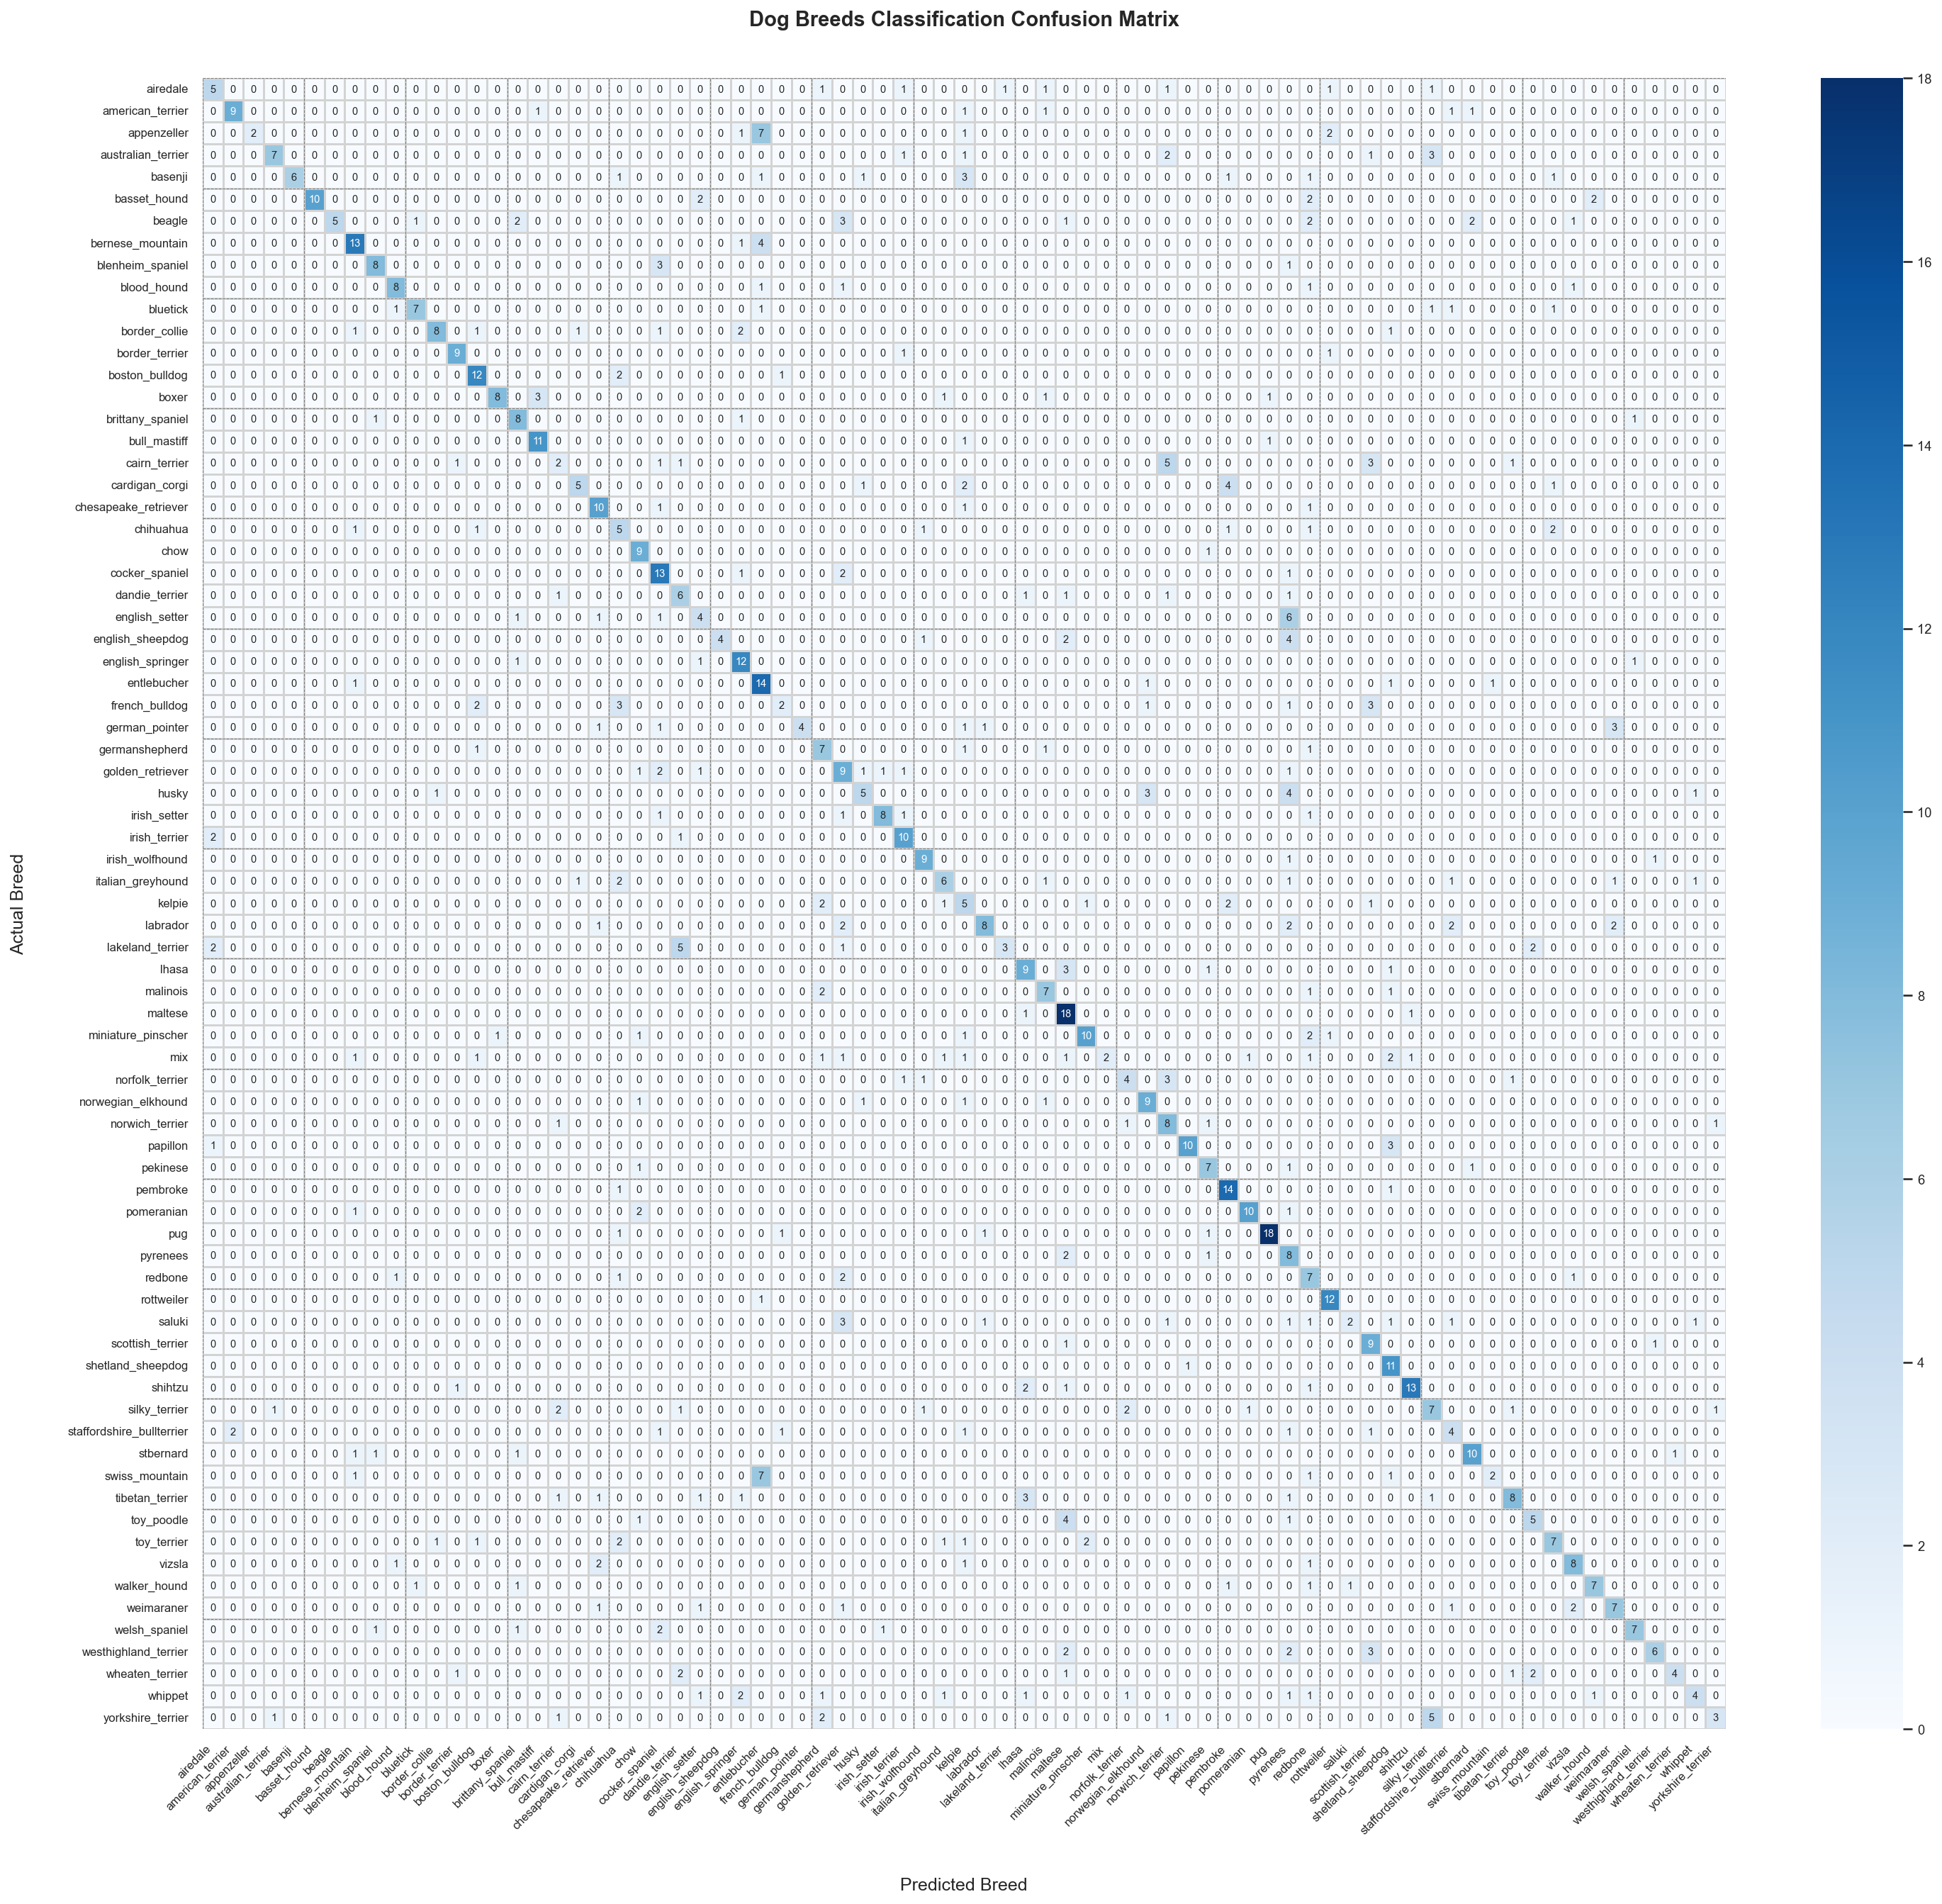

In [50]:
best_model = models.resnet18(weights=None)
num_ftrs = best_model.fc.in_features
best_model.fc = nn.Linear(num_ftrs, num_classes)

try:
    best_model.load_state_dict(torch.load('best_model_resnet18_pred.pth'))
except Exception as e:
    print(f"Ошибка загрузки модели: {e}")
    # Инициализация весов заново, если не удалось загрузить
    best_model.apply(weights_init)

best_model = best_model.to(device)

data_dir = 'C:/Users/User/.cache/kagglehub/datasets/darshanthakare/dog-breeds-image-dataset/versions/1/cropped_dogs'
dataset = ImageFolder(data_dir)
class_names = dataset.classes

# Тестирование
test_metrics = test_model(best_model, test_loader, class_names)
if test_metrics:
    test_accuracy, test_precision, test_recall, test_f1 = test_metrics
else:
    print("Не удалось получить метрики тестирования")

### ВЫВОД: на удивление данная модель показала себя хуже, чем логистическая регрессия. Это могло произойти из-за возможной недостаточной выборки и неверных аугментаций. 
#### Данная архитектура требует более чательной настройки, к сожалению на данный момент доработать ее не удалось